In [2]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np



# GET DATA

In [3]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = today
end_date = '2022-08-02'
#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
data_close = panel_data["Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close


,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1931.946777,3530.0,1837.5,1845.677368
2010-01-05,1931.946777,3550.0,1875.0,1865.630737
2010-01-06,1931.946777,3530.0,1862.5,1875.607300
2010-01-07,1973.945557,3420.0,1875.0,1865.630737
2010-01-08,1973.945557,3440.0,1887.5,1855.654053
...,...,...,...,...
2022-07-27,1785.000000,6100.0,9275.0,3510.000000
2022-07-28,2000.000000,6050.0,8975.0,3580.000000
2022-07-29,1955.000000,6325.0,8825.0,3560.000000


In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [6]:
def decompose(df):
    #To separate the trend and the seasonality from a time series, 
    # we can decompose the series using the following code.
    result = seasonal_decompose(df, model='multiplicative', period = 30)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(16, 9)

<AxesSubplot: ylabel='Density'>

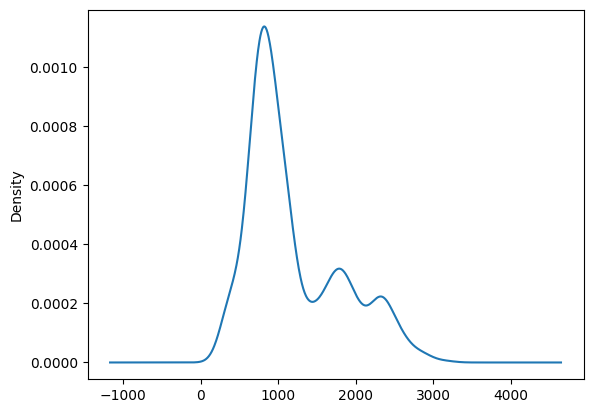

In [7]:
df_antm = data_close['antm']
#Distribution of the dataset
df_antm.plot(kind='kde')

<AxesSubplot: ylabel='Density'>

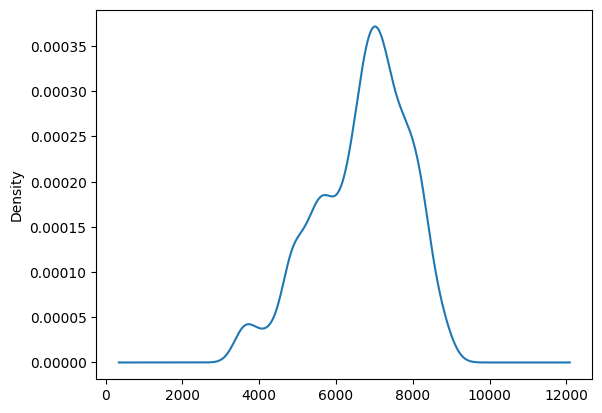

In [8]:
df_asii = data_close['asii']
#Distribution of the dataset
df_asii.plot(kind='kde')

<AxesSubplot: ylabel='Density'>

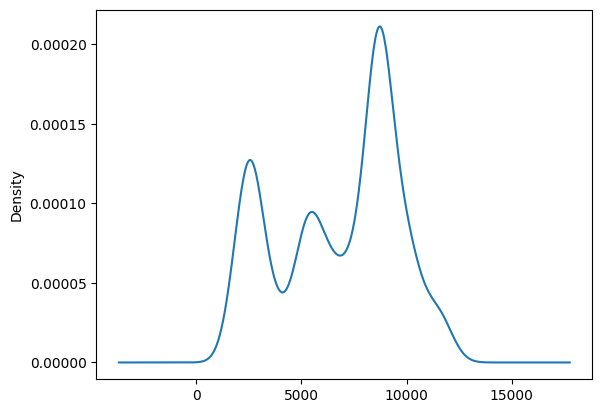

In [9]:
df_icbp = data_close['icbp']
#Distribution of the dataset
df_icbp.plot(kind='kde')

<AxesSubplot: ylabel='Density'>

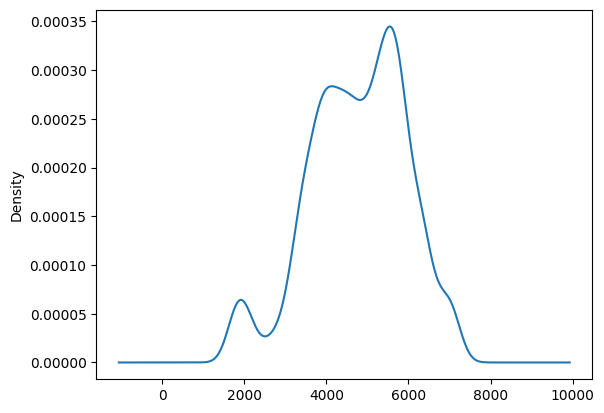

In [10]:
df_jsmr = data_close['jsmr']
#Distribution of the dataset
df_jsmr.plot(kind='kde')

# Test stationarity

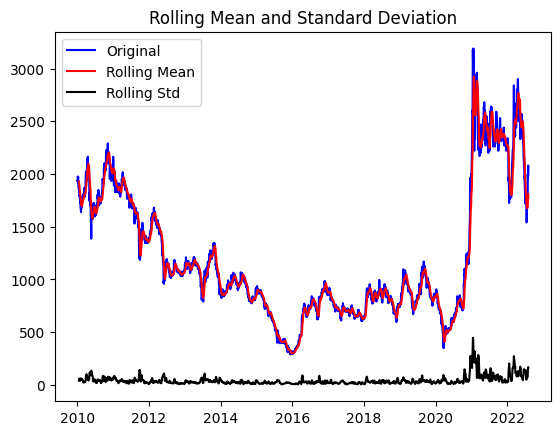

Results of dickey fuller test
Test Statistics                  -1.806029
p-value                           0.377473
No. of lags used                 25.000000
Number of observations used    3091.000000
critical value (1%)              -3.432467
critical value (5%)              -2.862476
critical value (10%)             -2.567268
dtype: float64


In [11]:
test_stationarity(df_antm)

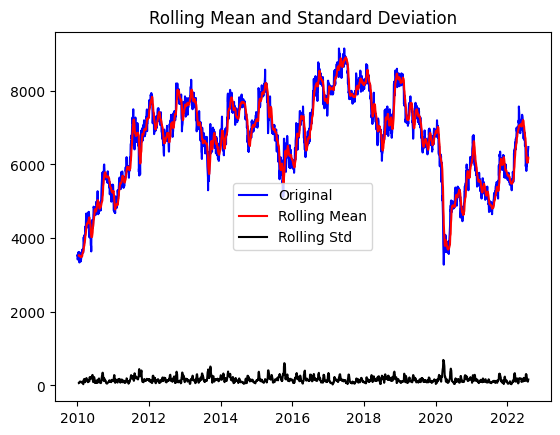

Results of dickey fuller test
Test Statistics                  -3.259464
p-value                           0.016791
No. of lags used                  6.000000
Number of observations used    3110.000000
critical value (1%)              -3.432454
critical value (5%)              -2.862470
critical value (10%)             -2.567265
dtype: float64


In [12]:
test_stationarity(df_asii)

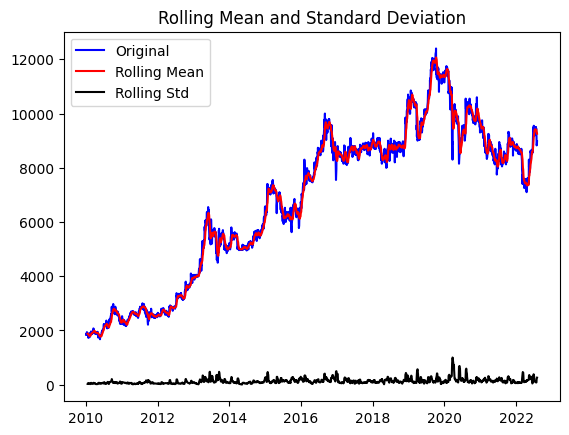

Results of dickey fuller test
Test Statistics                  -1.562921
p-value                           0.502188
No. of lags used                 13.000000
Number of observations used    3103.000000
critical value (1%)              -3.432459
critical value (5%)              -2.862472
critical value (10%)             -2.567266
dtype: float64


In [13]:
test_stationarity(df_icbp)

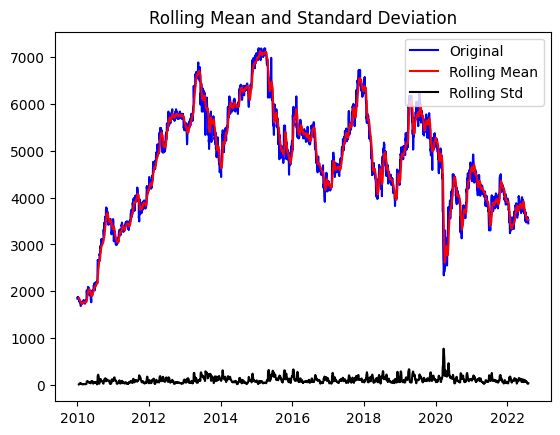

Results of dickey fuller test
Test Statistics                  -2.639419
p-value                           0.085121
No. of lags used                  3.000000
Number of observations used    3113.000000
critical value (1%)              -3.432452
critical value (5%)              -2.862469
critical value (10%)             -2.567264
dtype: float64


In [14]:
test_stationarity(df_jsmr)

# seasonal decompose

<Figure size 640x480 with 0 Axes>

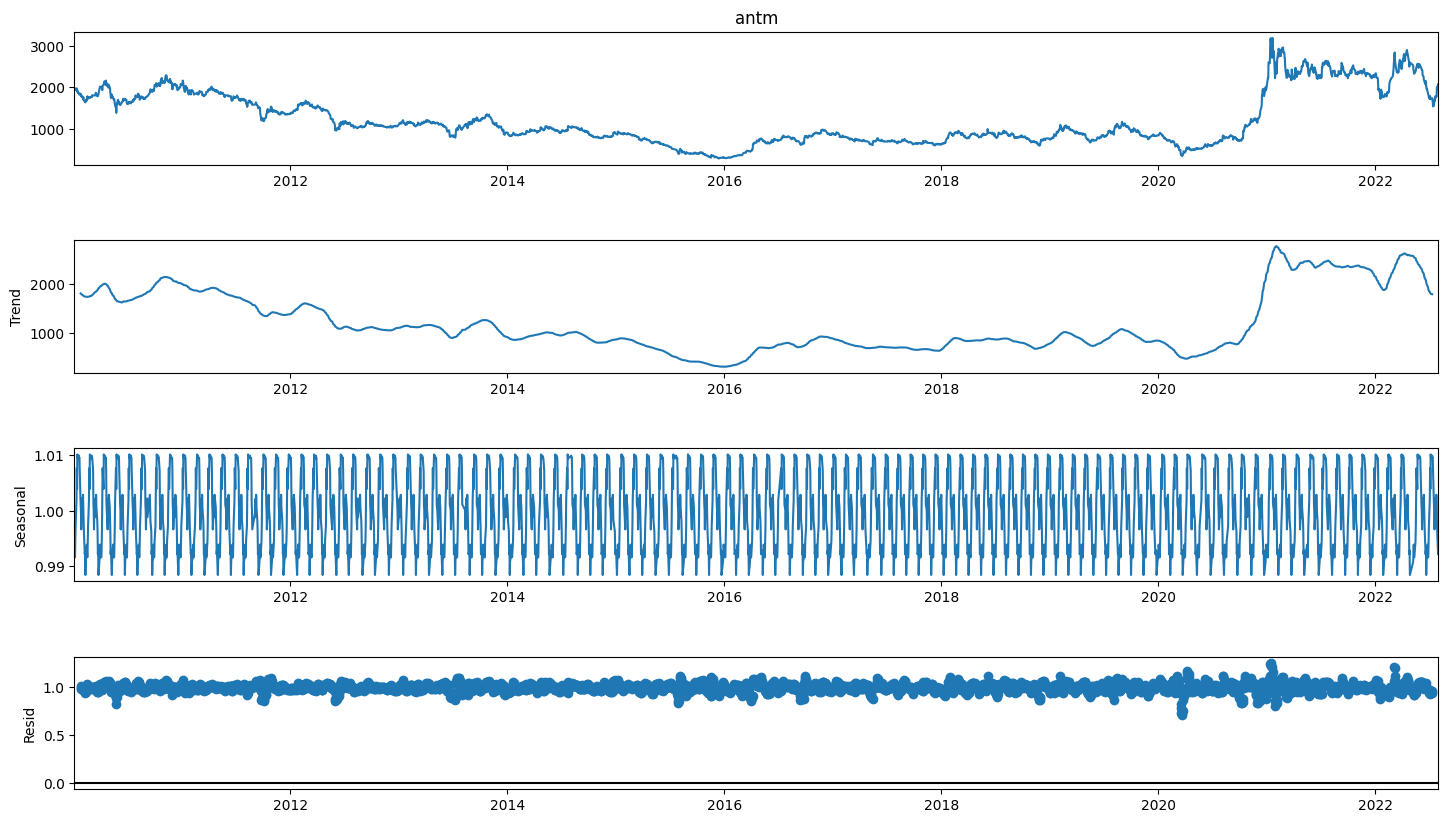

In [15]:
decompose(df_antm)

<Figure size 640x480 with 0 Axes>

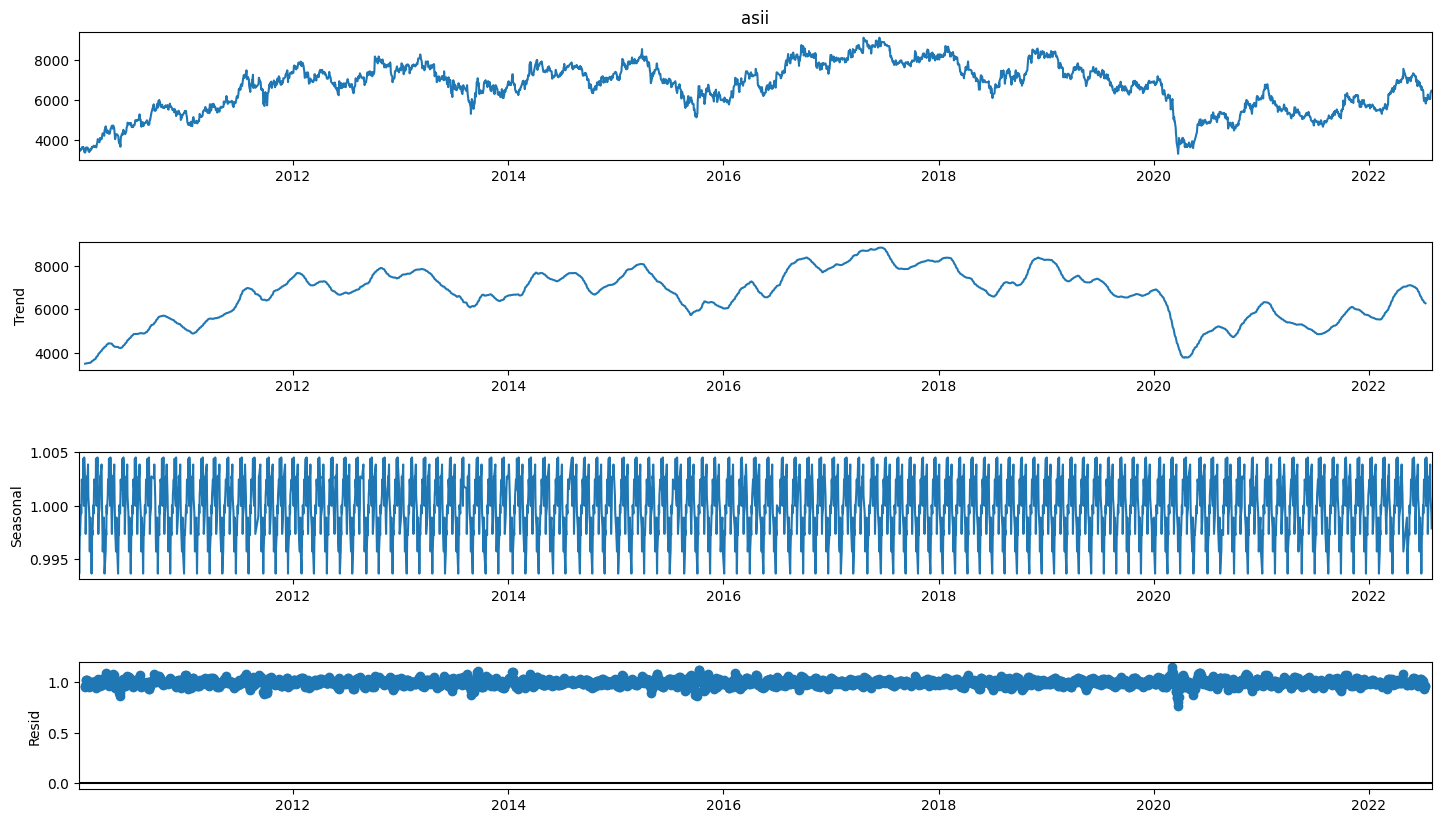

In [16]:
decompose(df_asii)

<Figure size 640x480 with 0 Axes>

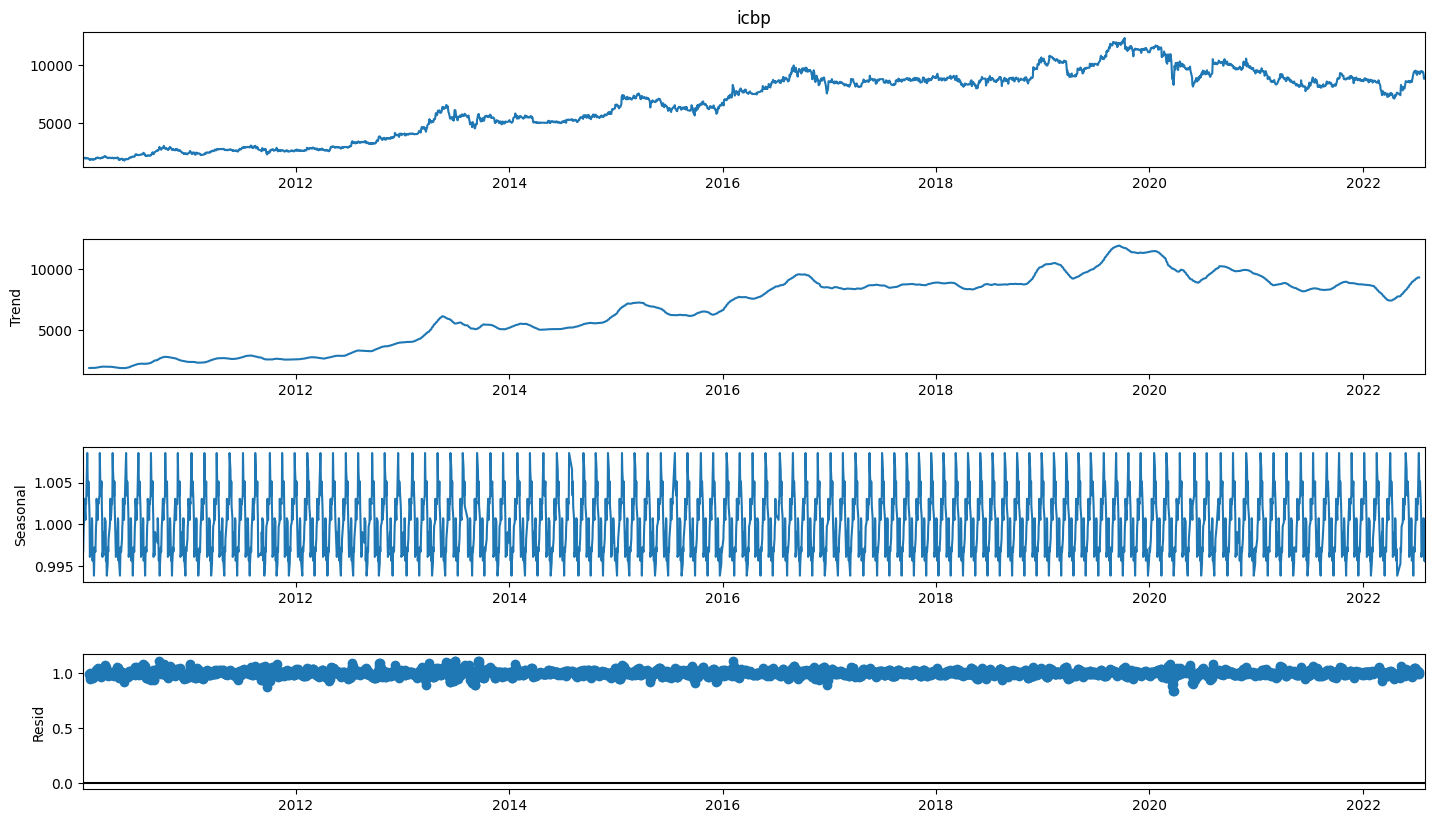

In [17]:
decompose(df_icbp)

<Figure size 640x480 with 0 Axes>

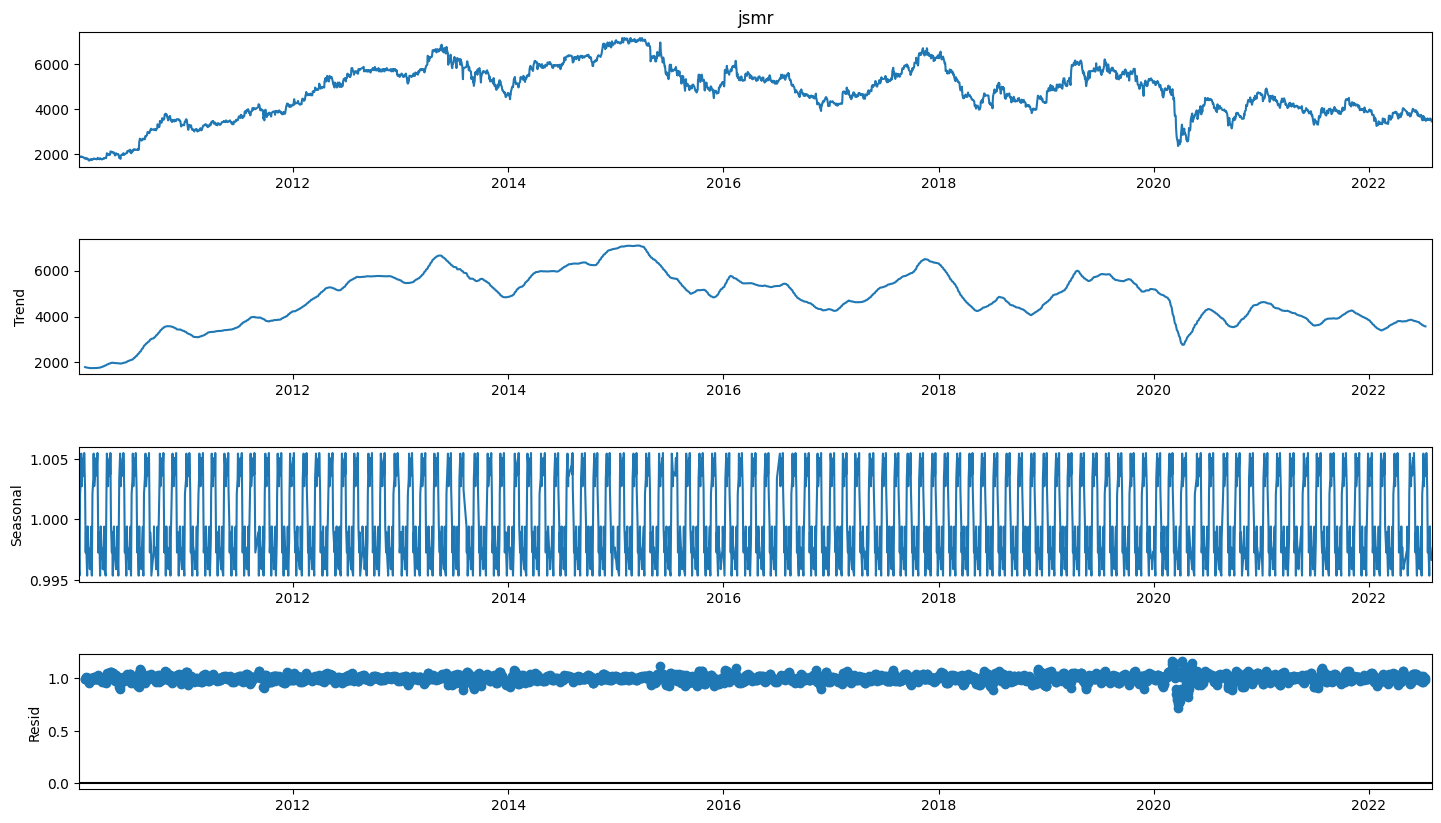

In [18]:
decompose(df_jsmr)

# Eliminate Trend

In [19]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
def eleminate_trend(df):
    rcParams['figure.figsize'] = 10, 6
    df_log = np.log(df)
    moving_avg = df_log.rolling(12).mean()
    std_dev = df_log.rolling(12).std()
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


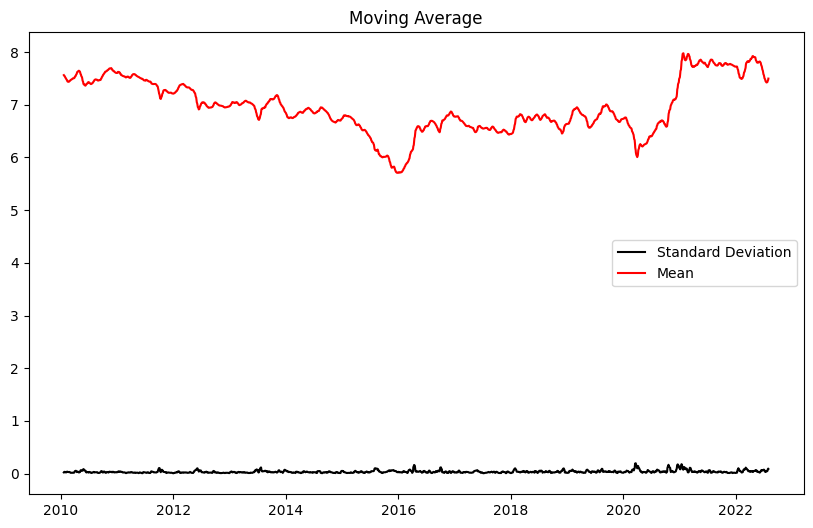

In [20]:
eleminate_trend(df_antm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


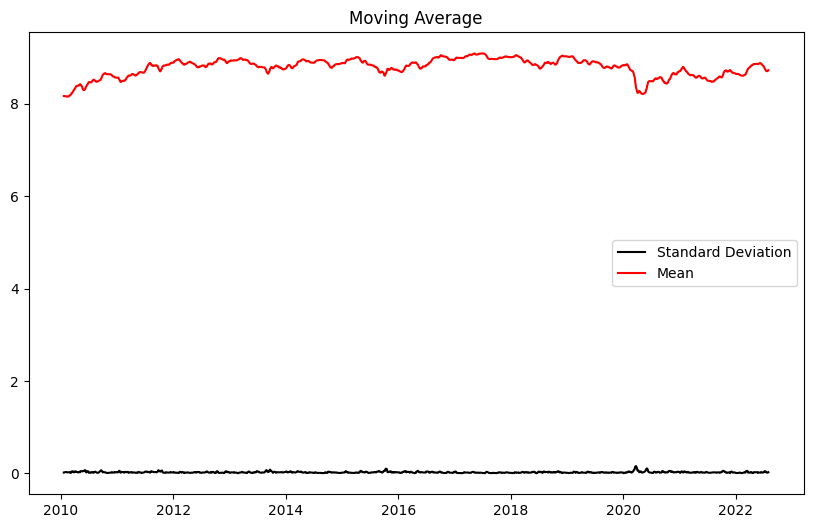

In [21]:
eleminate_trend(df_asii)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


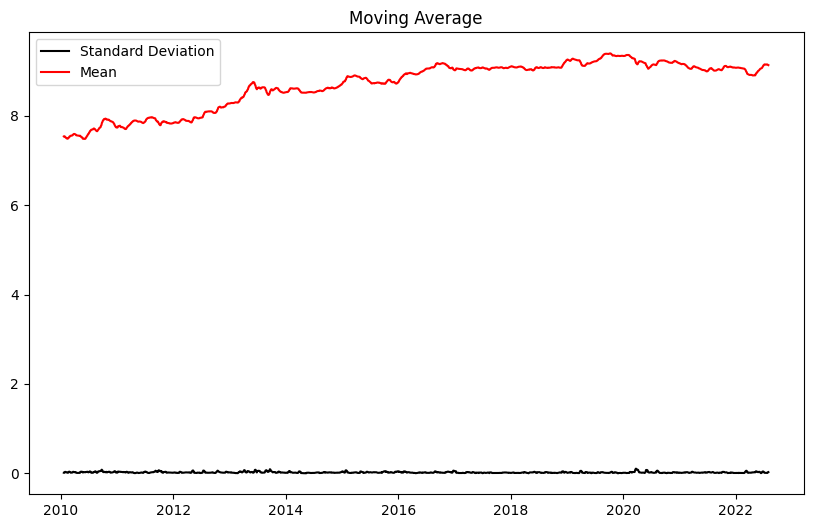

In [22]:
eleminate_trend(df_icbp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


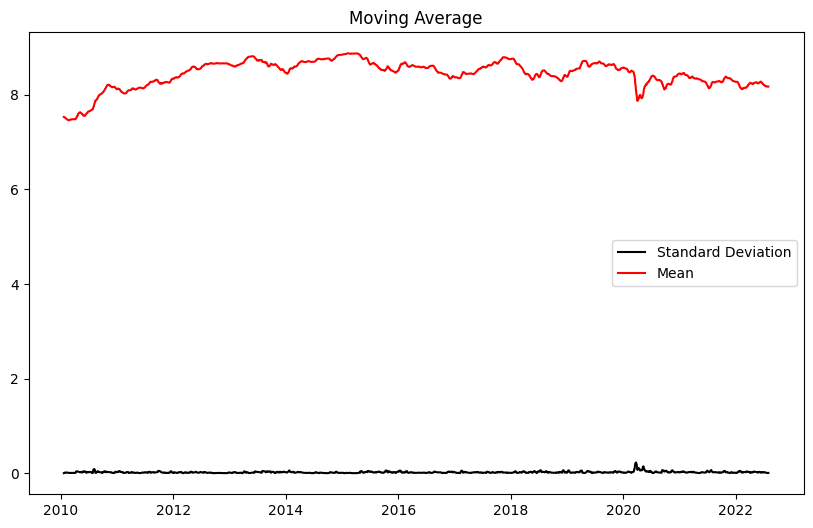

In [23]:
eleminate_trend(df_jsmr)

# Normalize Data

In [24]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [25]:
df_antm = normalize_data(df_antm, 'antm')
df_asii = normalize_data(df_asii, 'asii')
df_icbp = normalize_data(df_icbp, 'icbp')
df_jsmr = normalize_data(df_jsmr, 'jsmr')

# Split Data

In [26]:
def plot_split_data(df, test_data):
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()

In [27]:
def split_data(df):
    train_data = df[3:int(len(df)*0.33)]
    test_data =  df[int(len(df)*0.67):]
    plot_split_data(df,test_data)
    return train_data, test_data

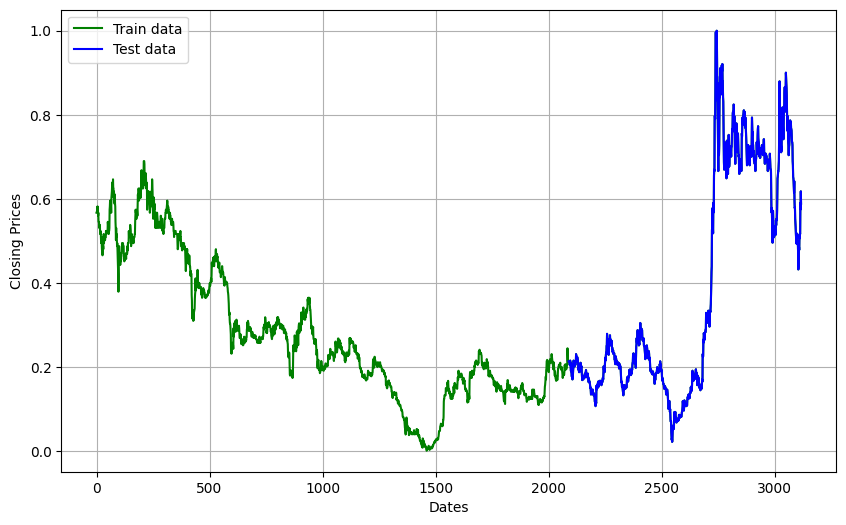

In [28]:
train_data_antm, test_data_antm = split_data(df_antm)

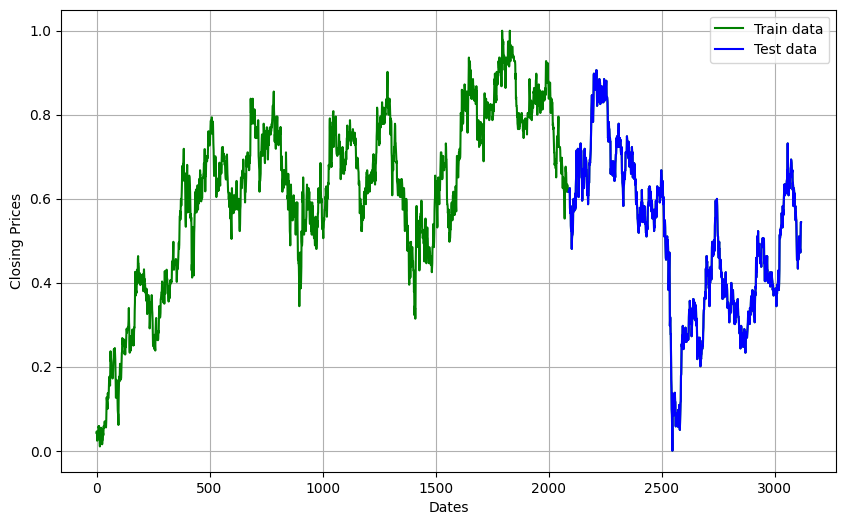

In [29]:
train_data_asii, test_data_asii = split_data(df_asii)

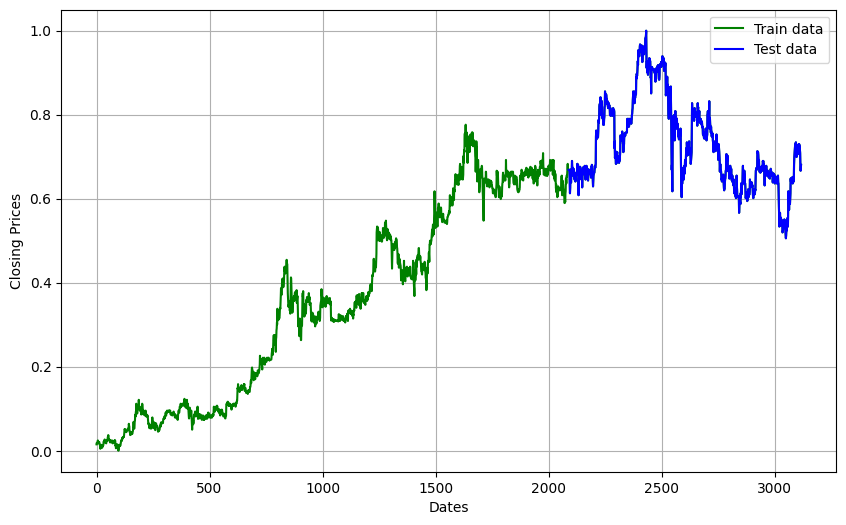

In [30]:
train_data_icbp, test_data_icbp = split_data(df_icbp)

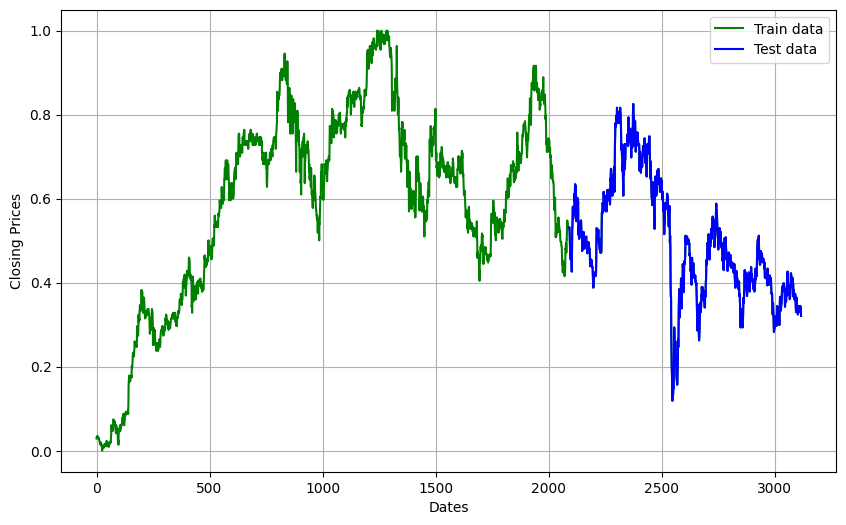

In [31]:
train_data_jsmr, test_data_jsmr = split_data(df_jsmr)

# AUTO ARIMA

In [32]:
def model_auto_arima(train_data):
    model_auto_arima = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model_auto_arima.summary())
    model_auto_arima.plot_diagnostics(figsize=(15,8))
    plt.show()

## ANTM

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6266.974, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6265.923, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6265.922, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6267.977, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6264.233, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.739 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1025
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3134.989
Date:                Wed, 19 Oct 2022   AIC                          -6267.977
Time:                        18:56:44   BIC                          -6263.046
Sample:                             0   HQIC                         -6266.105
                               - 1025                                  

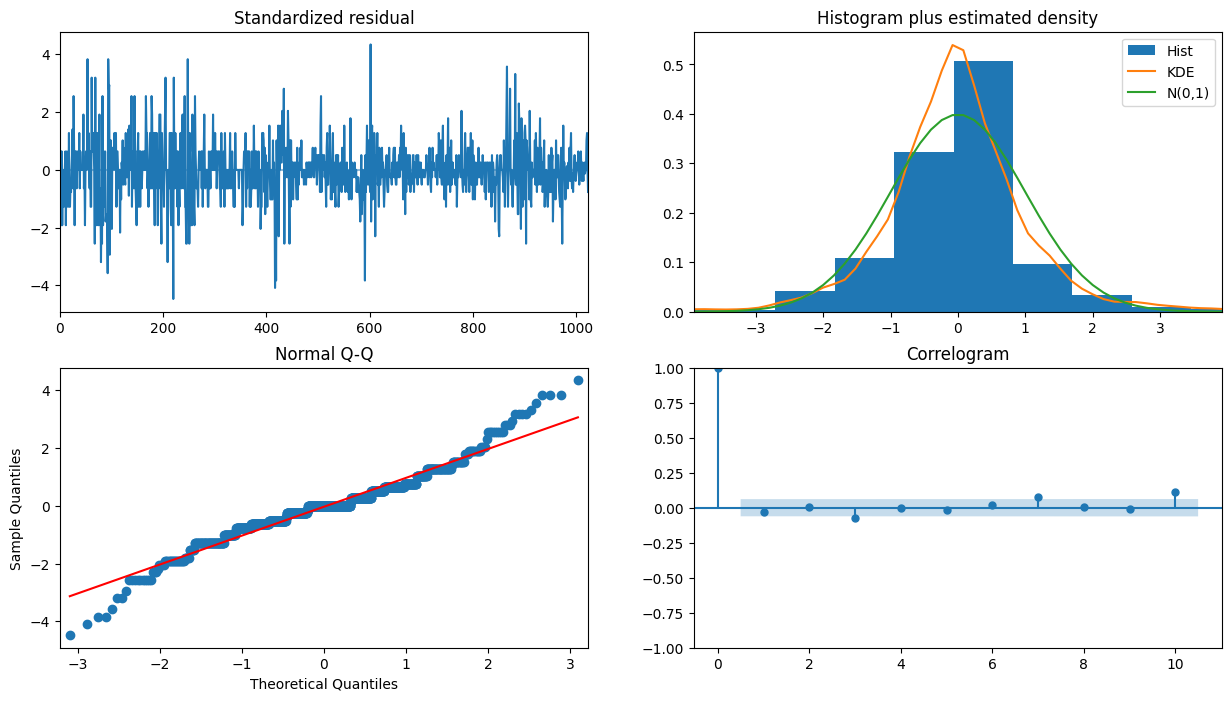

In [33]:
model_auto_arima(train_data_antm)

## ASII

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4806.932, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4805.159, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4805.162, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4808.143, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4803.167, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.593 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1025
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2405.071
Date:                Wed, 19 Oct 2022   AIC                          -4808.143
Time:                        18:56:47   BIC                          -4803.212
Sample:                             0   HQIC                         -4806.271
                               - 1025                                  

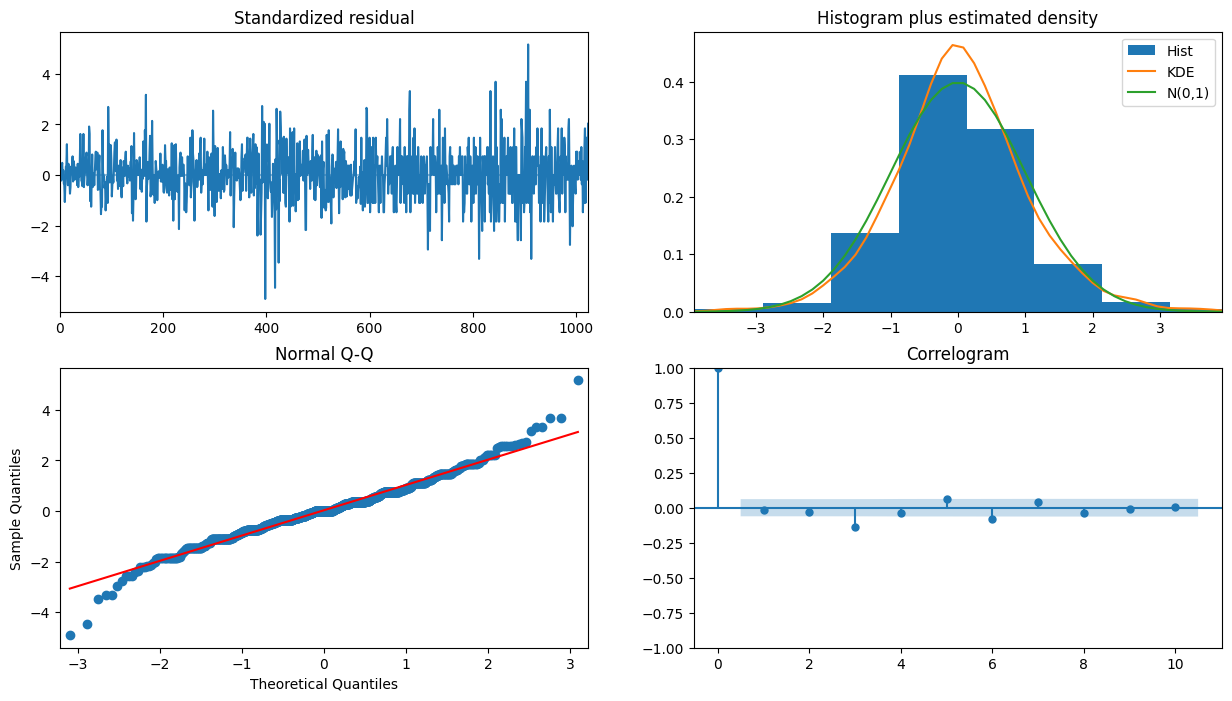

In [34]:
model_auto_arima(train_data_asii)

## ICBP

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7027.964, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7026.567, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7026.557, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7028.198, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7023.964, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.074 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1025
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3515.099
Date:                Wed, 19 Oct 2022   AIC                          -7028.198
Time:                        18:56:50   BIC                          -7023.267
Sample:                             0   HQIC                         -7026.326
                               - 1025                                  

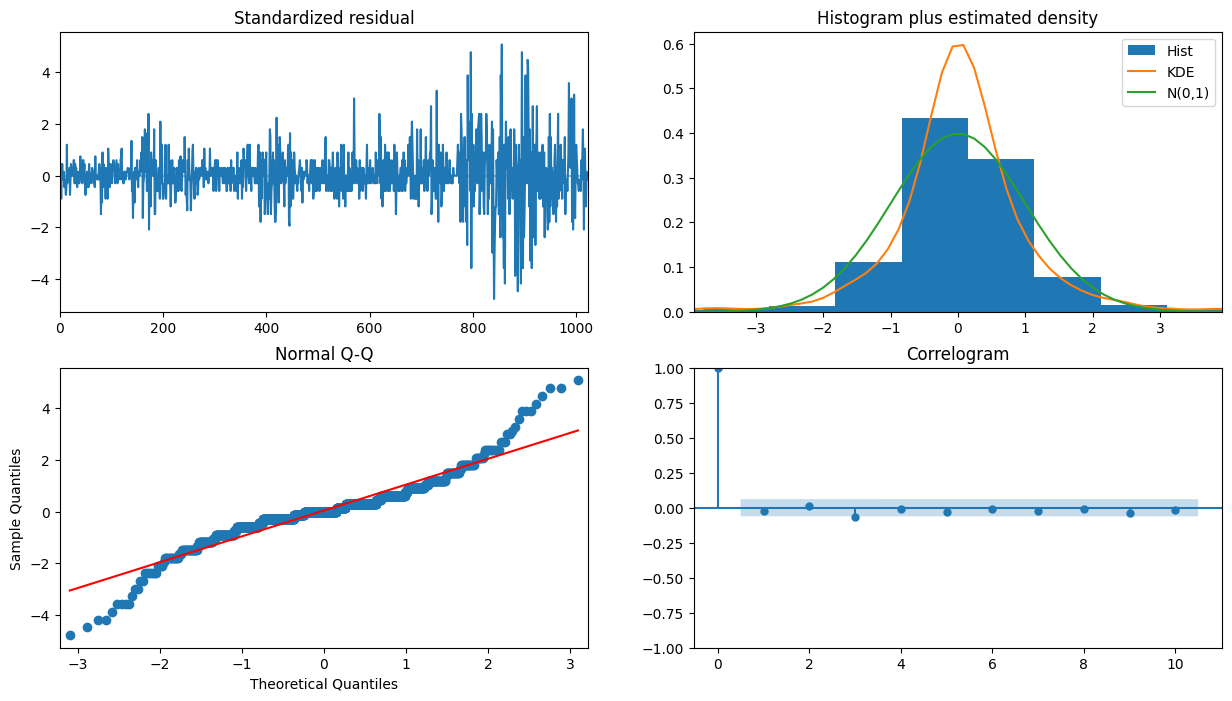

In [35]:
model_auto_arima(train_data_icbp)

## JSMR

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5623.177, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5622.550, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5622.726, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5623.367, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5620.632, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.206 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1025
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2812.683
Date:                Wed, 19 Oct 2022   AIC                          -5623.367
Time:                        18:56:52   BIC                          -5618.435
Sample:                             0   HQIC                         -5621.495
                               - 1025                                  

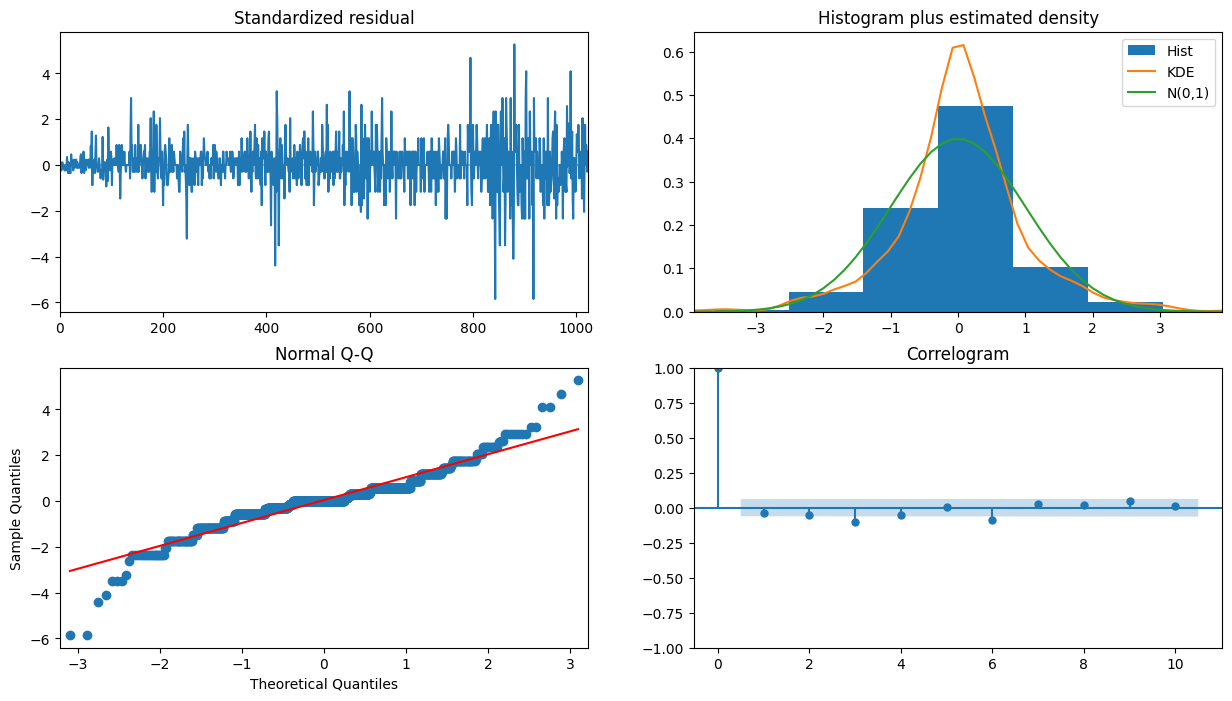

In [36]:
model_auto_arima(train_data_jsmr)

# MOdeling

## ANTM

In [37]:
#Modeling
# Build Model
model_ARIMA_antm = ARIMA(train_data_antm, order=(0,1,0))  
fitted_antm = model_ARIMA_antm.fit()  
print(fitted_antm.summary())

                               SARIMAX Results                                
Dep. Variable:                   antm   No. Observations:                 1025
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3134.989
Date:                Wed, 19 Oct 2022   AIC                          -6267.977
Time:                        18:56:53   BIC                          -6263.046
Sample:                             0   HQIC                         -6266.105
                               - 1025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   3.77e-06     33.992      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):               275.21
Prob(Q):                              0.33   Pr

## ASII

In [58]:
#Modeling
# Build Model
model_ARIMA_asii = ARIMA(train_data_asii, order=(0,1,0))  
fitted_asii = model_ARIMA_asii.fit()  
print(fitted_asii.summary())

                               SARIMAX Results                                
Dep. Variable:                   asii   No. Observations:                 1025
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2405.071
Date:                Wed, 19 Oct 2022   AIC                          -4808.143
Time:                        19:16:52   BIC                          -4803.212
Sample:                             0   HQIC                         -4806.271
                               - 1025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.65e-05     32.380      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               186.76
Prob(Q):                              0.63   Pr

## ICBP

In [59]:
#Modeling
# Build Model
model_ARIMA_icbp = ARIMA(train_data_icbp, order=(0,1,0))  
fitted_icbp = model_ARIMA_icbp.fit()  
print(fitted_icbp.summary())

                               SARIMAX Results                                
Dep. Variable:                   icbp   No. Observations:                 1025
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3515.099
Date:                Wed, 19 Oct 2022   AIC                          -7028.198
Time:                        19:17:02   BIC                          -7023.267
Sample:                             0   HQIC                         -7026.326
                               - 1025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.102e-05   1.45e-06     42.022      0.000    5.82e-05    6.39e-05
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):              1018.40
Prob(Q):                              0.44   Pr

## JSMR

In [61]:
#Modeling
# Build Model
model_ARIMA_jsmr = ARIMA(train_data_jsmr, order=(0,1,0))  
fitted_jsmr = model_ARIMA_jsmr.fit()  
print(fitted_jsmr.summary())

                               SARIMAX Results                                
Dep. Variable:                   jsmr   No. Observations:                 1025
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2812.683
Date:                Wed, 19 Oct 2022   AIC                          -5623.367
Time:                        19:17:48   BIC                          -5618.435
Sample:                             0   HQIC                         -5621.495
                               - 1025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002    5.7e-06     42.231      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):              1074.73
Prob(Q):                              0.24   Pr

# FORECAST

In [62]:
def forecasting_antm(df):
    fc_df = fitted_antm.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [63]:
def forecasting_asii(df):
    fc_df = fitted_asii.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [64]:
def forecasting_icbp(df):
    fc_df = fitted_icbp.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [65]:
def forecasting_jsmr(df):
    fc_df = fitted_jsmr.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [66]:
fc_antm = forecasting_antm(test_data_antm)
fc_asii = forecasting_asii(test_data_asii)
fc_jsmr = forecasting_jsmr(test_data_jsmr)
fc_icbp = forecasting_icbp(test_data_icbp)

In [67]:
fc_antm_train = forecasting_antm(train_data_antm)
fc_asii_train = forecasting_asii(train_data_asii)
fc_jsmr_train = forecasting_jsmr(train_data_jsmr)
fc_icbp_train = forecasting_icbp(train_data_icbp)

# MEtric Evaluation

In [68]:
def pembulatan(data,number):
    return np.round(data,number)

In [69]:
from sklearn.metrics import mean_absolute_percentage_error
def metric_eval(df_data, fc, lb_saham,number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(fc, df_data)))
    print("mape score "+str(mean_absolute_percentage_error(fc, df_data)))
    print("rmse score "+str(np.sqrt(mean_squared_error(fc, df_data))))
    print("round up")
    print("mae score: "+str(pembulatan(mean_absolute_error(fc, df_data),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(fc, df_data),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(fc, df_data)),number)))

In [70]:
metric_eval(fc_antm,test_data_antm ,'antm',4)

Matriks score for antm
mae score: 0.22265357273287256
mape score 0.5578281754144309
rmse score 0.3140364020218915
round up
mae score: 0.2227
mape score 0.5578
rmse score 0.314


In [71]:
metric_eval(train_data_antm,fc_antm_train, 'antm',4)

Matriks score for antm
mae score: 0.18348606343745014
mape score 0.836234420271889
rmse score 0.2225946849800046
round up
mae score: 0.1835
mape score 0.8362
rmse score 0.2226


In [72]:
metric_eval(test_data_asii,fc_asii, 'asii',4)

Matriks score for asii
mae score: 0.20912697033059996
mape score 0.3072779263681157
rmse score 0.25895576409676885
round up
mae score: 0.2091
mape score 0.3073
rmse score 0.259


In [73]:
metric_eval(train_data_asii,fc_asii_train, 'asii',4)

Matriks score for asii
mae score: 0.1938413595379565
mape score 0.28481821789431905
rmse score 0.26070501753334363
round up
mae score: 0.1938
mape score 0.2848
rmse score 0.2607


In [74]:
metric_eval(test_data_icbp,fc_icbp, 'icbp',4)

Matriks score for icbp
mae score: 0.37865196028461334
mape score 1.0793467838013233
rmse score 0.39277073342901364
round up
mae score: 0.3787
mape score 1.0793
rmse score 0.3928


In [75]:
metric_eval(train_data_icbp,fc_icbp_train, 'icbp',4)

Matriks score for icbp
mae score: 0.2026346011711865
mape score 0.5776095940361397
rmse score 0.22958947821491352
round up
mae score: 0.2026
mape score 0.5776
rmse score 0.2296


In [76]:
metric_eval(test_data_jsmr,fc_jsmr, 'jsmr',4)


Matriks score for jsmr
mae score: 0.21760522184052936
mape score 0.3106229879372948
rmse score 0.24976098458322651
round up
mae score: 0.2176
mape score 0.3106
rmse score 0.2498


In [77]:
metric_eval(train_data_jsmr,fc_jsmr_train, 'jsmr',4)

Matriks score for jsmr
mae score: 0.25739543164311385
mape score 0.3674219643358868
rmse score 0.3360868497758603
round up
mae score: 0.2574
mape score 0.3674
rmse score 0.3361
